In [43]:
from copy import deepcopy as dc

import math
#import scipy
#from scipy import optimize
#import scipy.interpolate
#from scipy.optimize import curve_fit

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from streakimage import StreakImage
#from streakimage2 import StreakImage

mpl.rcParams.update({'font.size': 20})
mpl.rcParams.update({'lines.linewidth': 3})
plt.rcParams["figure.figsize"] = (12,9)

import glob
import os


from numpy import asarray as ar,exp
#import statistics

### Functions

In [67]:
def plot_pc(img,save="",title=""): #Plot a simple Heatmap with posiblity to save
    plt.pcolormesh(
    img.columns,
    img.index,
    img,
    shading="nearest",
    cmap="viridis", 
    norm=mpl.colors.LogNorm(),
    )
    plt.colorbar()
    plt.xlabel("Wavelength in nm")
    plt.ylabel("pixel")
    plt.title(title)
    if save != "":
        plt.savefig(f".{save}.png", dpi=500,bbox_inches='tight',    transparent=True)
    plt.show()
    
def apply_to_all_in_dict(dict_: dict, func): # Applies a given Function to all elements of a given dictionary
    for key in dict_:
        if type(dict_[key])==dict:
            apply_to_all_in_dict(dict_[key], func)
        else:
            func(dict_[key])
            func(dict_[key].ref)
            
def all_corrections(img: emccd): #All Corrections are apllied to a given StreakImage-Object 
    img.apply_gain_correction()
    img.apply_exp_correction()
    offset_from_corner(img)
    #img.apply_camera_correction()
    #img.apply_mono_correction()
    #apply_mono_correction1(img)
    

    
def offset_from_corner(img: emccd): #The Rectange which is used for the Offset correction is chosen
    #plot_pc(img.data.iloc[1013:-1,1013:-1]) #Line that displays a heatmap of a section of the heatmap
    img.data -= img.data.iloc[0:30,0:30].mean().mean() # iloc sets the lines and colums that are chosen for the offset rectangle
    #x=1+1
    
def show_dict(img_dict, indent=0): #Displays all entrys of a given dictionary, including their keys and oject-types 
    tab = "\t"
    for key in img_dict:
        if type(img_dict[key]) == dict:
            print(tab * indent, key)
            show_dict(img_dict[key], indent + 1)
        else:
            print(tab * indent, key)
            print(tab * (indent + 1), img_dict[key])
            
            
def plot_section(df: pd.DataFrame, #Dataframe to be analyszied
    ax,                            #axes where the graph is plotted
    steps=1,                       #number of graphs in one plot
    wl_min=None,
    wl_max=None,
    t_min=None,
    t_max=None,
    style='-',
    linewidth=3,
    norm="",
    log="",
    xmin="",
    xmax="",
    ymin="",
    ymax="",
    fit="",
                ):
#     height=640
#     width=512
    
    a,b = df.axes
    lis=[]
  
    if (wl_min==None and wl_max ==None) and (t_min!=None and t_max!=None ): # Betrachtung Spektren
        if ((t_min > t_max) or (t_min < a.min()) or (t_max > a.max())):
            print("Selected Time out of range!")
            return
            
        for i in range(1, steps+1):
            rng_t=t_max - t_min
            name=t_min+(i-1)*(rng_t/steps)
            data=closest_val(a,name)
            lis.append(str(round(data,3))+" ps")
            #data= int(round((i/steps)*width)) 
            temp_max=max(df.loc[data,:])
            temp_min=min(df.loc[data,:])
            
            
            
            
            
            if fit=="yes":
                val=dc(df.loc[data,:])
                grau=gauss_fit(val.index.tolist(),val.tolist())
                val=pd.Series(data=dc(grau), index=val.index.tolist())
                ax.plot((val-min(val))/(max(val)-min(val)),style, linewidth=linewidth)
            else:
                     
                if norm=="":
                    ax.plot(df.loc[data,:],style, linewidth=linewidth)
                elif norm=="yes":
                    ax.plot((df.loc[data,:]-temp_min)/(temp_max-temp_min),style, linewidth=linewidth)            
            ax.set_xlabel("Wavelenght in nm",fontsize=30)
            ax.set_ylabel("Intensity in arbitrary units",fontsize=30)
        if t_min!=t_max:
            data=closest_val(a,t_max)
            lis.append(str(round(data,3))+" ps")
            temp_max=max(df.loc[data,:])
            temp_min=min(df.loc[data,:])
            
            if fit=="yes":
                val=dc(df.loc[data,:])
                grau=gauss_fit(val.index.tolist(),val.tolist())
                val=pd.Series(data=dc(grau), index=val.index.tolist())
                ax.plot((val-min(val))/(max(val)-min(val)),style, linewidth=linewidth)
            else:   
                if norm=="":
                    ax.plot(df.loc[data,:],style, linewidth=linewidth)
                elif norm=="yes":
                    ax.plot((df.loc[data,:]-temp_min)/(temp_max-temp_min),style, linewidth=linewidth)
            ax.set_xlabel("Wavelenght in nm",fontsize=30)
            ax.set_ylabel("Intensity in arbitrary units",fontsize=30)
        if norm=="yes":
            ax.set_ylim([0, 1])
        else:
            if ymin!="" and ymax!="":
                ax.set_ylim([ymin, ymax])
            
        if xmin!="" and xmax!="":
            ax.set_xlim([xmin, xmax])
        if log=="yes":
            ax.set_yscale("log")
        
            
        return lis
    
    elif(wl_min!=None and wl_max!=None) and (t_min==None and t_max==None ):# Betrachtung Transienten
        if (wl_min > wl_max or wl_min < b.min() or wl_max > b.max()):
            print("Selected WL out of range!")
            return lis
        for i in range(1, steps+1):
            rng_wl=wl_max - wl_min
            name=int(round(wl_min+(i-1)*(rng_wl/steps)))
            data=closest_val(b,name)
            temp_max=max(df.loc[:,data])
            temp_min=min(df.loc[:,data])
            lis.append(str(round(data,3))+" nm") 
            if norm=="":
                ax.plot(df.loc[:,data],style, linewidth=linewidth)
            elif norm=="yes":
                ax.plot((df.loc[:,data]-temp_min)/(temp_max-temp_min),style, linewidth=linewidth)
            ax.set_xlabel("Time in ps",fontsize=30)
            ax.set_ylabel("Intensity in arbitrary units",fontsize=30)
        if wl_max!=wl_min:
            data=closest_val(b,wl_max)
            lis.append(str(round(data,3))+" nm") 
            temp_max=max(df.loc[:,data])
            temp_min=min(df.loc[:,data])
            if norm=="":
                ax.plot(df.loc[:,data],style, linewidth=linewidth)
            elif norm=="yes":
                ax.plot((df.loc[:,data]-temp_min)/(temp_max-temp_min),style, linewidth=linewidth)
            ax.set_xlabel("Time in ps",fontsize=30)
            ax.set_ylabel("Intensity in arbitrary units",fontsize=30)
            
        if log=="yes":
            ax.set_yscale("log") 
            
        if ymin!="" and ymax!="":
            ax.set_ylim([ymin, ymax])
            
        if xmin!="" and xmax!="":
            ax.set_xlim([xmin, xmax])
        

        
        return lis

    
def plot_section_spez(df: pd.DataFrame, #Dataframe to be analyszied
    ax,                            #axes where the graph is plotted
    style='-',
    linewidth=3,
    norm="",
    log="",
    xmin="",
    xmax="",
    ymin="",
    ymax="",
    wl_list=[],
    t_list=[]
                ):
#     height=640
#     width=512
    
    a,b = df.axes
    lis=[]
    wl_listc=dc(wl_list)
    t_listc=dc(t_list)
    
    if (len(wl_listc)==0) and (len(t_list)!=0): # Betrachtung Spektren
        for i in range (len(t_listc)):
            name=t_listc.pop(0)
            data=closest_val(a,name)
            lis.append(str(round(data,3))+" ps") 
            temp_max=max(df.loc[data,:])
            temp_min=min(df.loc[data,:])
            if norm=="":
                ax.plot(df.loc[data,:],style, linewidth=linewidth)
            elif norm=="yes":
                ax.plot((df.loc[data,:]-temp_min)/(temp_max-temp_min),style, linewidth=linewidth)            
            ax.set_xlabel("Wavelenght in nm")
            ax.set_ylabel("Intensity in arbitrary units")
        if norm=="yes":
            ax.set_ylim([0, 1])
        else:
            if ymin!="" and ymax!="":
                ax.set_ylim([ymin, ymax])
            
        if xmin!="" and xmax!="":
            ax.set_xlim([xmin, xmax])
        if log=="yes":
            ax.set_yscale("log")
        
            
        return lis
    
    elif(len(wl_listc)!=0) and (len(t_listc)==0):# Betrachtung Transienten
        for i in range (len(wl_listc)):
            name=wl_listc.pop(0)
            data=closest_val(b,name)
            temp_max=max(df.loc[:,data])
            temp_min=min(df.loc[:,data])
            lis.append(str(round(data,3))+" nm") 
            if norm=="":
                ax.plot(df.loc[:,data],style, linewidth=linewidth)
            elif norm=="yes":
                ax.plot((df.loc[:,data]-temp_min)/(temp_max-temp_min),style, linewidth=linewidth)
            ax.set_xlabel("Time in ps")
            ax.set_ylabel("Intensity in arbitrary units")
            
        if log=="yes":
            ax.set_yscale("log") 
            
        if ymin!="" and ymax!="":
            ax.set_ylim([ymin, ymax])
            
        if xmin!="" and xmax!="":
            ax.set_xlim([xmin, xmax])

        return lis    
    

def closest_val(l:list, val): #Returns the closest claue to a given scalar contained in a given list
    temp=[]
    for i in l:            
        temp.append(abs(i-val))
    return l[temp.index(min(temp))]

            
def plot_all_img_in_dict(     #Plots Heatmaps of all the Streakimage-Objects within a given Dictionary 
    img_dict: dict,           
    line_length=3,            # How many Heatmaps are Displayed per line
    from_t=None,              
    to_t=None,                
    from_wl=None,
    to_wl=None,
    from_row=None,
    to_row=None,
    from_col=None,
    to_col=None,
    shading="nearest",
    cmap="viridis",
    norm=mpl.colors.LogNorm,
    vmin=None,              # Minimum Value Displayed in the Heatmap            
    vmax=None,              # Maximum Value Displayed in the Heatmap
    save="",                # Name under which a png of the plots is saved
):
    mpl.rcParams.update(mpl.rcParamsDefault)
    nox = math.ceil(len(img_dict) / line_length)
    noy = line_length if len(img_dict) >= line_length else len(img_dict)

    fig_hm, axes_hm = plt.subplots(nox, noy, figsize=(6 * noy, 4 * nox))

    x = 0
    for key in img_dict:
        img = img_dict[key]
        ax = fig_hm.axes[x]
        hm = plot_heatmap(
            img.data.loc[from_t:to_t, from_wl:to_wl].iloc[
                from_row:to_row, from_col:to_col
            ],
            fig_hm,
            ax=ax,
            shading=shading,
            cmap=cmap,
            norm=norm,
            vmin=vmin,
            vmax=vmax,
            title=key
        )
        x += 1
    if save != "":
        fig_hm.savefig(f"./heatmaps/{save}_heatmap.png", dpi=300, transparent=True)
    #plt.show()
    
def plot_all_abs_in_dict(     #Plots Heatmaps of all the Streakimage-Objects within a given Dictionary 
    img_dict: dict,           
    line_length=3,            # How many Heatmaps are Displayed per line
    from_y=None,              
    to_y=None,                
    from_wl=None,
    to_wl=None,
    from_row=None,
    to_row=None,
    from_col=None,
    to_col=None,
    shading="nearest",
    cmap="viridis",
    norm=mpl.colors.LogNorm,
    vmin=None,              # Minimum Value Displayed in the Heatmap            
    vmax=None,              # Maximum Value Displayed in the Heatmap
    save="",                # Name under which a png of the plots is saved
):
    mpl.rcParams.update(mpl.rcParamsDefault)
    nox = math.ceil(len(img_dict) / line_length)
    noy = line_length if len(img_dict) >= line_length else len(img_dict)

    fig_hm, axes_hm = plt.subplots(nox, noy, figsize=(6 * noy, 4 * nox))

    x = 0
    for key in img_dict:
        img = img_dict[key]
        ax = fig_hm.axes[x]
        hm = plot_heatmap(
            img.abs.loc[from_y:to_y, from_wl:to_wl].iloc[
                from_row:to_row, from_col:to_col
            ],
            fig_hm,
            ax=ax,
            shading=shading,
            cmap=cmap,
            norm=norm,
            vmin=vmin,
            vmax=vmax,
            title=key
        )
        x += 1
    if save != "":
        fig_hm.savefig(f"./heatmaps/{save}_heatmap.png", dpi=300, transparent=True)
    #plt.show()
        
def plot_heatmap(      #Plots a Heatmap of a given Pandas Dataframe
    df: pd.DataFrame,
    fig: mpl.figure.Figure,
    ax,
    shading="nearest",
    cmap="jet",
    norm=mpl.colors.LogNorm,
    vmin=None,          #Minimum displayed value
    vmax=None,          #Maximum displayed value
    title: str = None,  #Title of the pLot
):
    hm = ax.pcolormesh(
        df.columns,
        df.index,
        df,
        shading=shading,
        cmap=cmap,
        norm=norm(vmin=vmin, vmax=vmax),        
    )
    fig.colorbar(hm, ax=ax)
    ax.set_ylabel("Time in ps", fontsize=12)
    ax.set_xlabel("Wavelength in nm",fontsize=12)
    if title:
        ax.set_title(title)
    plt.tight_layout()
        




def closest_val2(l,val): #Findes the first closest value to a given scalar in a list
    diff=9999999
    j=0
    for i in l:
        if i<1:
            if abs(i-val)<diff:
                diff=abs(i-val)
                j=i
        else:
            return j
    return 0
        
    
def pos_in_df(df, val): #Returns the index and column number of a scalar in a dataframe 
    i, c = np.where(df == val)
    return int(i), int(c)

def xy_val_df(df, val): #Returns the x and y value of a given scalar in a dataframe
    x,y=pos_in_df(df,val)
    x1=df.columns[x]
    y1=df.index[y]
    return x1, y1


def pos_in_ser(df, val): #Returns the index number of a scalar in a pandas-series
    i = np.where(df == val)
    i=int(i[0])
    return i

def x_val_ser(df, val): #Returns the x-value of a given scalar in a pandas series
    x=pos_in_ser(df,val)
    x1=df.index[x]
    return x1

def overlapp_flanks(dic): #Working Function to make transients overlapp for all streakimages in a dict by overlapping the mean of the flanks
    low=0.3
    high=0.5
    
    dict_=dc(dic)
    dict_ser={}
    midpoints={}
    indexe={}
    b=0
    avg=0
    
    for i in dict_:           #Go through dict
        val=np.sum(dict_[i].data,1) #calculate sum of each pixel row
        val_max=max(val)
        val_min=min(val)
        val=(val-val_min)/(val_max-val_min)
        
        data_list=val.to_list()
        
        wstart=closest_val2(data_list,low)
        wend=closest_val2(data_list,high)
        
        xstart=x_val_ser(val,wstart)
        xend=x_val_ser(val,wend)
        xmid=(xend-xstart)/2+xstart
        
        a=closest_val2(val.index.to_list(),xmid)
        midpoints[i]=a
        indexe[i]=val.index.to_list()
        
        b=b+a
    
    avg=b/len(dict_) # average the x value of the transient maximum
    print(avg)

    for i in dict_: #Go through dict

        a=midpoints[i]
        offs=avg-a #Calculate offset of maximum from the average
        as_list = indexe[i]
        as_list = [x+offs for x in as_list]
        dict_[i].data.index=dc(as_list) #override the old index values    
    return dict_
     
        
def norm_df_lines(df,           #Returns a copy of a Dataframe with each indivdual Line or Column normalized
                  hor="",       # if hor=="yes": lines get normalized
                  ver=""):      # if ver=="yes": columns get normalized
    df_c=dc(df)
    cols=len(list(df.columns))
    ind=len((list(df.index)))
    if hor=="yes":
        for i in df_c.index:
            max_l=max(df_c.loc[i])
            min_l=min(df_c.loc[i])
            r_list=[]
            for j in df_c.loc[i]:
                #new_j=(j-min_l)/(max_l-min_l)
                new_j=j/max_l
                r_list.append(new_j)
            df_c.loc[i] = r_list
            
    if ver=="yes":
        for i in df_c.columns:
            max_l=max(df_c.loc[:,i])
            min_l=min(df_c.loc[:,i])
            r_list=[]
            for j in df_c.loc[:,i]:
                #new_j=(j-min_l)/(max_l-min_l)
                new_j=j/max_l
                r_list.append(new_j)
            df_c.loc[:,i] = r_list
                
    return df_c  

def norm_dict_df_lines(dict_,hor="",ver=""):    #Returns a copy of a Dictionary of Dataframes with each indivdual Line or Column normalized
    dict_c=dc(dict_)
    dict_new={}
    for i in dict_c:
        new_df=norm_df_lines(dict_[i].data, hor=hor, ver=ver)
        dict_c[i].data=new_df
        dict_new[i]=dc(dict_c[i])
    return dict_new



    
    
    
    
def gauss_fit_for_diffusion(arg1,arg2,center_avg):
    
    #print(arg1[arg2.index(max(arg2))])
    init_vals = [max(arg2),center_avg, 30]  # for [amp, cen, wid]
    x = ar(arg1)
    y = ar(arg2)

    n = len(x)                          #the number of data
    mean = sum(x*y)/n                   #note this correction
    sigma = sum(y*(x-mean)**2)/n        #note this correction

    popt,pcov = curve_fit(gaus,x,y,p0=[ init_vals])
    #print(pcov)
    #plt.plot(x,y,'b+:',label='data')
    #plt.plot(x,gaus(x,*popt),'ro:',label='fit')
    #plt.legend()
    #plt.title('Fig. 3 - Fit for Time Constant')
    #plt.xlabel('Time (s)')
    #plt.ylabel('Voltage (V)')
    #plt.show()
    #print(*popt)
    return popt[2]
        

def gaus(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))

def linear(x,m,b):
    return x*m+b

def stat_aus(daten):                     #statistical evaluation of data in a given list, returns the mean, standard deviation and the absolute and relative errors
    mean=np.mean(daten)
    stab=statistics.stdev(daten)
    absf=stab/math.sqrt(len(daten))
    relf=absf/mean
    print('Mittelwert:;'+str(mean))
    print('Standardabweichung:;'+str(stab))
    print('absoluter Fehler:;'+str(absf))
    print('relativer Fehler:;'+str(relf))
    
    
def calc_diffusion(st,                   # Function that calculated the diffusion coefficent of a PL measurement @ 0th-order; plots temporal progression of the spotradius
                   beam_radius,          # Beam Radius in um
                   start_t=None,         # Starting time in ps
                   save="",              # pngs get saved in "plots"-folder
                   name="",              # Title of the plot
                   return_="",           # if return=="yes": Function returns pandas-series with the 
                   mode="normal",        # if mode=="squared": plots the square of the radii on the y-axis
                   end_t="",
                   l_start_t=[],
                   l_end_t=[],
                   fit="",
                   x_lim=[],
                   y_lim=[]):            # End time in ps
    
    mpl.rcParams.update({'font.size': 15})
    mpl.rcParams.update({'lines.linewidth': 3})
    df=st.data
    widths=[]
    df_c=dc(df)
    y_vals=[]
    slopes=[]
    D=[]
    
    sum_spec= np.sum(df)
    sum_trans=np.sum(df,1)
    #plt.plot(sum_trans)
    t0=x_val_ser(sum_trans,max(sum_trans))
    diff_max=0
    counter=0
    for i in range(len(sum_trans)):
        if i!=0:
            diff=sum_trans.iloc[i]-sum_trans.iloc[i-1]
            if diff>diff_max:
                counter=i
                diff_max=diff
    t0=sum_trans.iloc[counter]     
    center_avg=x_val_ser(sum_spec,max(sum_spec))
    
    for i in df_c.index:
        max_l=max(df_c.loc[i])
        min_l=min(df_c.loc[i])
        r_list=[]
        r_list=dc(list(df_c.loc[i]))
        try:
            d=gauss_fit_for_diffusion(df_c.columns.tolist(),r_list,center_avg)
        except RuntimeError:
            d=0
        widths.append(d)
    w0_pos=counter
    w0=widths[w0_pos]
    #w0=min(widths)
    t=list(df_c.index)
    
    if start_t!=None:
        t0_pos=closest_val( t,start_t)
        w0_pos=t.index(t0_pos)
        w0=widths[w0_pos]
        
    else:    
        for i in range(w0_pos-1):
            widths.pop(0)
            t.pop(0)
        
    if start_t!=None:
        for i in range(w0_pos-1):
            widths.pop(0)
            t.pop(0)

    if end_t!="":
        while t[-1]>end_t:
            t.pop(-1)
            widths.pop(-1)
  
    t=t-t0
    widths_resized=[number*(beam_radius/w0) for number in widths]
    
    #lgd=plt.legend(l,bbox_to_anchor=(1.05, 1), loc='upper left')
    
            
    
    #plt.show()
    init_vals=[1,beam_radius**2]
    widths_squared=[number ** 2 for number in widths_resized]
    #plt.plot(t,widths_squared)
    l=[]
    if mode=="normal":
        plt.plot(t,widths_resized)    
    elif mode=="squared":
        plt.plot(t,widths_squared)
    elif mode=="no plot":
        None
    if len(x_lim)!=0:
        plt.xlim(x_lim[0],x_lim[1])
    if len(y_lim)!=0:
        plt.ylim(y_lim[0],y_lim[1])
    plt.xlabel("Time in ps")
    plt.ylabel("\u03C3²(t) in µm²")
    
    
    if save != "":
        plt.savefig(f"./plots/{save}_diffusion.png", dpi=300,bbox_inches='tight',transparent=True)
    if len(l_start_t)!=0 and len(l_start_t)==len(l_end_t):
        for i in range(len(l_start_t)):
            tx=[]
            tx_calc=[]
            wx=[]
            y_vals=[]
            for time in range(len(t)):
                if t[time]>=l_start_t[i] and t[time]<=l_end_t[i]:
                    tx.append(t[time])
                    tx_calc.append(t[time]-l_start_t[i])
                    wx.append(widths_squared[time])
            popt,pcov = curve_fit(lambda tx_calc, m: linear(tx_calc, m, wx[0]), tx_calc, wx)
            perr = np.sqrt(np.diag(pcov))
            slopes.append(popt[0])
            for timex in range(len(tx)):
                y_vals.append(tx_calc[timex]*popt[0]+wx[0])
            plt.plot(tx,y_vals,color="black",linestyle="--",linewidth="2")
            print(f"{i+1}ter Abschnitt: {popt[0]*500} +/- {perr[0]*500} cm²/s")
        ser_new=pd.Series(data=widths_squared,index=t)
        return ser_new, slopes
            
    else:
        popt,pcov = curve_fit(lambda t, m: linear(t, m, beam_radius**2), t, widths_squared)
        perr = np.sqrt(np.diag(pcov)) #Calculate Stadard Deviation of Fitted Values
    
    if mode== "no plot":
        None
    else:        
        print(f"{popt[0]*500} +/- {perr[0]*500} cm²/s")
        if fit=="yes":
            for i in t:
                y_vals.append(i*popt[0]+beam_radius**2)
            plt.plot(t,y_vals,color="black")
    
    if return_=="yes":
        if mode=="normal":
            ser_new=pd.Series(data=widths_resized,index=t)
        elif mode=="squared":
            ser_new=pd.Series(data=widths_squared,index=t)
        elif mode=="no plot":
            ser_new=pd.Series(data=widths_squared,index=t)
        return ser_new
    
def calc_diffusion_dict(dict_,             # Calculate the diffusion coefficients for all entrys in a dictionary; plots the progression of spotradii all @ once and seperate 
                        beam_radius=2,
                        start_t=None,
                        save="",
                        return_="yes",
                        line_length=3,
                        mode="squared",
                        end_t="",
                        l_start_t=[],
                        l_end_t=[],
                        fit="",
                        x_lim=[],
                        y_lim=[]):   
    ser_dict={}
    slopes_dict={}
    slopes=[]
    l=[]
    for i in dict_:
        print(i)
        if len(l_start_t)!=0 and len(l_start_t)==len(l_end_t):
            ser_new,slopes=calc_diffusion(dict_[i],beam_radius=beam_radius,start_t=start_t,name=i,return_="yes",mode="squared", end_t=end_t,l_start_t=l_start_t,l_end_t=l_end_t,x_lim=x_lim,y_lim=y_lim)
        elif fit=="yes":
            ser_new_1=calc_diffusion(dict_[i],beam_radius=beam_radius,start_t=0,name=i,return_="yes",mode="no plot", end_t=end_t,fit="",x_lim=x_lim,y_lim=y_lim)
            ser_new=calc_diffusion(dict_[i],beam_radius=ser_new_1.loc[closest_val(ser_new_1.index,start_t)],start_t=start_t,name=i,return_="yes",mode=mode, end_t=end_t,fit=fit,x_lim=x_lim,y_lim=y_lim)
        else:
            ser_new=calc_diffusion(dict_[i],beam_radius=beam_radius,start_t=start_t,name=i,return_="yes",mode=mode, end_t=end_t,fit=fit,x_lim=x_lim,y_lim=y_lim)
        ser_dict[i]=dc(ser_new)
        slopes_dict[i]=dc(slopes)
        l.append(i)
    lgd=plt.legend(l,bbox_to_anchor=(1.05, 1), loc='upper left')
    if save != "":
        plt.savefig(f"./plots/{save}_diffusion_all.png", dpi=300,bbox_inches='tight', bbox_extra_artists=(lgd,),transparent=True)
    
    nox = math.ceil(len(dict_) / line_length)
    noy = line_length if len(dict_) >= line_length else len(img_dict)

    fig_hm, axes_hm = plt.subplots(nox, noy, figsize=(8 * noy, 6 * nox))
    x = 1
    for key in ser_dict:
        plt.subplot(nox,noy,x)
        plt.plot(ser_dict[key])
        if len(slopes_dict[key])!=0:
            for i in range(len(slopes_dict[key])):
                x_vals=[]
                x_vals_calc=[]
                y_vals=[]
                y_vals_new=[]
                x_vals1=ser_dict[key].index
                y_vals1=list(ser_dict[key].array)
                for x1 in range(len(x_vals1)):
                    if x_vals1[x1]>=l_start_t[i] and x_vals1[x1]<=l_end_t[i]:
                        x_vals.append(x_vals1[x1])
                        x_vals_calc.append(x_vals1[x1]-l_start_t[i])
                        y_vals.append(y_vals1[x1])
                        y_vals_new.append(y_vals[0]+slopes_dict[key][i]*x_vals_calc[-1])
                plt.plot(x_vals,y_vals_new,color="black",linestyle="--",linewidth="2")
        plt.title(key)
        plt.xlabel("Time in ps")
        plt.ylabel("\u03C3²(t) in µm²")
 
        x += 1
    if save != "":
        plt.savefig(f"./plots/{save}_diffusion_seperate.png", dpi=300,bbox_inches='tight', bbox_extra_artists=(lgd,),transparent=True)
    plt.show()


def calc_Ds(       st,                   # Function that calculated the diffusion coefficent of a PL measurement @ 0th-order; plots temporal progression of the spotradius
                   beam_radius,          # Beam Radius in um
                   start_t=None,         # Starting time in ps
                   save="",              # pngs get saved in "plots"-folder
                   name="",              # Title of the plot
                   return_="",           # if return=="yes": Function returns pandas-series with the 
                   end_t="",
                   l_start_t=[],
                   l_end_t=[],
                   fit="",
                   x_lim=[],
                   y_lim=[]):            # End time in ps
    
    mpl.rcParams.update({'font.size': 15})
    mpl.rcParams.update({'lines.linewidth': 3})
    df=st.data
    widths=[]
    df_c=dc(df)
    y_vals=[]
    slopes=[]
    D=[]
    
    sum_spec= np.sum(df)
    sum_trans=np.sum(df,1)
    #plt.plot(sum_trans)
    t0=x_val_ser(sum_trans,max(sum_trans))
    diff_max=0
    counter=0
    for i in range(len(sum_trans)):
        if i!=0:
            diff=sum_trans.iloc[i]-sum_trans.iloc[i-1]
            if diff>diff_max:
                counter=i
                diff_max=diff
    t0=sum_trans.iloc[counter]     
    center_avg=x_val_ser(sum_spec,max(sum_spec))
    
    for i in df_c.index:
        max_l=max(df_c.loc[i])
        min_l=min(df_c.loc[i])
        r_list=[]
        r_list=dc(list(df_c.loc[i]))
        try:
            d=gauss_fit_for_diffusion(df_c.columns.tolist(),r_list,center_avg)
        except RuntimeError:
            d=0
        widths.append(d)
    w0_pos=counter
    w0=widths[w0_pos]
    #w0=min(widths)
    t=list(df_c.index)
    
    if start_t!=None:
        t0_pos=closest_val( t,start_t)
        w0_pos=t.index(t0_pos)
        w0=widths[w0_pos]
        
    else:    
        for i in range(w0_pos-1):
            widths.pop(0)
            t.pop(0)
        
    if start_t!=None:
        for i in range(w0_pos-1):
            widths.pop(0)
            t.pop(0)

    if end_t!="":
        while t[-1]>end_t:
            t.pop(-1)
            widths.pop(-1)
  
    t=t-t0
    widths_resized=[number*(beam_radius/w0) for number in widths]
    init_vals=[1,beam_radius**2]
    widths_squared=[number ** 2 for number in widths_resized]
    for i in range(len(widths_squared)):
        D.append((widths_squared[i]-widths_squared[0])*1000/(2*t[i]))
    #plt.plot(t,widths_squared)
    l=[]
    #plt.figure(figsize=(8, 6), dpi=80)
    plt.plot(t,D)    
    if len(x_lim)!=0:
        plt.xlim(x_lim[0],x_lim[1])
    if len(y_lim)!=0:
        plt.ylim(y_lim[0],y_lim[1])
    plt.xlabel("Time in ps")
    plt.ylabel("Diffusion constant")  
    
    if save != "":
        plt.savefig(f"./plots/{save}_diffusion_coefficients.png", dpi=300,bbox_inches='tight',transparent=True)
    
    
    if return_=="yes":
        ser_new=pd.Series(data=D,index=t)
        return ser_new
def calc_Ds_dict(dict_,beam_radius=2,start_t=0,end_t=2000):
    for i in dict_:
        calc_Ds(dict_[i],beam_radius,start_t=start_t,end_t=end_t)
    plt.show()

### Functions for Plotting Spectra and Transients of a given Dictionary with possible verticle line

In [68]:
def plot_spec_and_trans(dict_,             
                        save="",           # pngs get saved in the "plots"-folder
                        vline=999999,      #plot a vertical line @ a given time in ps
                        yscale="",         # if yscale=="log": the transients get plotted with a logarithmic y-scale
                        norm="yes",
                        ylim_min=0.01,
                        ylim_max=1.1,
                        many_vals="",
                        lstyle="-"):       # if norm=="yes": the plots get normalized
    
    mpl.rcParams.update({'font.size': 20})
    mpl.rcParams.update({'lines.linewidth': 3})
    
    l=[]
    plt.figure(figsize=(15,10))
    count=0
    for i in dict_:
        count=count+1
        val= np.sum(dict_[i].data)
        val_max=max(val)
        val_min=min(val)
        
        if count>10:
            lstyle=":"
        if norm=="yes":
            plt.plot((val-val_min)/(val_max-val_min),linestyle=lstyle)
        elif norm=="no":
            plt.plot(val,linestyle=lstyle)
            
        plt.xlabel("Wavelength in nm")
        plt.ylabel("normalized Intensity")
        if vline!=999999:
            if norm=="no":
                plt.vlines(vline,ymin=val_min,ymax=val_max)
            elif norm=="yes":
                plt.vlines(vline,ymin=0,ymax=1)
                

            close_x=closest_val(val.index,vline)
            
            if norm=="yes":
                close_y=(val[close_x]-val_min)/(val_max-val_min)
            elif norm=="no":
                close_y=(val[close_x])
               
            
            print(f"{i}  {close_x} : {close_y}")
        l.append(i)
  
    #lgd=plt.legend(l,bbox_to_anchor=(1.05, 1.0), loc='upper left')
    lgd=plt.legend(l)
    
    if save != "":
        plt.savefig(f"./plots/{save}_spectrum.png", dpi=300,bbox_inches='tight', bbox_extra_artists=(lgd,),transparent=True)
    
    #plt.savefig(f"./files/morphology_spectrum_comparison.png", dpi=300,bbox_inches='tight', bbox_extra_artists=(lgd,),transparent=True)
    
    l=[]
    count=0
    lstyle="-"
    plt.figure(figsize=(15,10))
    for i in dict_:
        count=count+1
        if count>10:
            lstyle=":"
        val= np.sum(dict_[i].data,1)
        val_max=max(val)
        val_min=min(val)
        
        if norm=="yes":
            plt.plot((val-val_min)/(val_max-val_min),linestyle=lstyle)
        elif norm=="no":
            plt.plot(val,linestyle=lstyle)
            
        if yscale=="log":
            plt.yscale("log")
        plt.ylim(ylim_min,ylim_max)
        plt.xlabel("Time in ps")
        plt.ylabel("normalized Intensity")
        l.append(i)
  
    lgd=plt.legend(l,bbox_to_anchor=(1.05, 1), loc='upper left')
    
    if save != "":
        plt.savefig(f"./plots/{save}_transient.png", dpi=300,bbox_inches='tight', bbox_extra_artists=(lgd,),transparent=True)
    

def color():
    return    
    
def plot_spec_and_trans_style(dict_,               #Same function as plot_spec_and_trans but in addition a specified area of the dataframe can be plotted and specific colors can be chosen for each plot
                              save="",
                              wlmin="",            #Constraints
                              wlmax="",
                              tmin="",
                              tmax="",
                              color_func=color):   # color function which determines the color selection of the plots
    
    mpl.rcParams.update({'font.size': 20})
    mpl.rcParams.update({'lines.linewidth': 3})
    
    l=[]
    plt.figure(figsize=(15,10))
    for i in dict_:
        val= np.sum(dict_[i].data)
        
        
        if wlmin!="" or wlmax!="":
            wlmin=closest_val(val.index.tolist(),wlmin)
            wlmax=closest_val(val.index.tolist(),wlmax)
            val=val.loc[wlmin:wlmax]
        val_max=max(val)
        val_min=min(val)
        plt.plot((val-val_min)/(val_max-val_min),color=color_func(i),linestyle=symbol(i))
        plt.xlabel("Wavelength in nm")
        plt.ylabel("normalized Intensity")
        l.append(i)
  
    lgd=plt.legend(l,bbox_to_anchor=(1.05, 1.0), loc='upper left')
    #lgd=plt.legend(l)
    
    if save != "":
        plt.savefig(f"./plots/{save}_spectrum.png", dpi=300,bbox_inches='tight', bbox_extra_artists=(lgd,),transparent=True)
    
    #plt.savefig(f"./files/morphology_spectrum_comparison.png", dpi=300,bbox_inches='tight', bbox_extra_artists=(lgd,),transparent=True)
    
    l=[]
    plt.figure(figsize=(15,10))
    for i in dict_:
        val= np.sum(dict_[i].data,1)
        if tmin!="" or tmax!="":
            tmin=closest_val(val.index.tolist(),tmin)
            tmax=closest_val(val.index.tolist(),tmax)
            val=val.loc[tmin:tmax]
        val_max=max(val)
        val_min=min(val)
        plt.plot((val-val_min)/(val_max-val_min),color=color_func(i),linestyle=symbol(i))
        plt.xlabel("Time in ps")
        plt.ylabel("normalized Intensity")
        l.append(i)
  
    #lgd=plt.legend(l,bbox_to_anchor=(1.05, 1.0), loc='upper left')
    lgd=plt.legend(l)
    
    if save != "":
        plt.savefig(f"./plots/{save}_transient.png", dpi=300,bbox_inches='tight', bbox_extra_artists=(lgd,),transparent=True)
    plt.show()
    


### EMCCD Klasse

In [69]:
class emccd:   #Das ist die EMCCD-Klasse sie ließt alle Daten aus den .asc-files ein und speichert diese in Attributen, das wichtigeste ist .data, da das den Dataframe mit dem 2D-Plot zurückgibt
    def __init__(self,path,bg=None,ref=None):
        self.path=path
        self.bg=dc(bg)
        self.ref=dc(ref)
        txt=open(self.path,'r')
        lst=[]
        x_axis=[]
        for line in txt:
            if len(line)>1000 or line[0].isdigit():
                temp=line.split()
                val_s=temp.pop(0)
                val_i=val_s.replace(",",".")
                val_i=float(val_i)
                x_axis.append(val_i)
                A = [float(y) for y in temp]
                lst.append(dc(A))
                continue
                
            if (line=="\n"):
                continue
            if (line=="KY328i:\n"):
                continue
            cat,entry=line.split(":",1)
            entry=" ".join(entry.split())
            if (cat=="Date and Time"):
                self.date=dc(entry)
            elif (cat=="Software Version"):
                self.sversion=dc(entry)
            elif (cat=="Unstabilized Temperature (C)"):
                self.temp=dc(entry)
            elif (cat=="Model"):
                self.model=dc(entry)
            elif (cat=="Data Type"):
                self.dtype=dc(entry)
            elif (cat=="Acquisition Mode"):
                self.acquisiton=dc(entry)
            elif (cat=="Trigger Mode"):
                self.trigger=dc(entry)
            elif (cat=="Exposure Time (secs)"):
                self.exposure=dc(entry).replace(",",".")
            elif (cat=="Accumulate Cycle Time (secs)"):
                self.cyclet=dc(entry)
            elif (cat=="Frequency (Hz)"):
                self.freq=dc(entry)
            elif (cat=="Number of Accumulations"):
                self.nr_acc=dc(entry)
            elif (cat=="Readout Mode"):
                self.readout_mode=dc(entry)
            elif (cat=="Horizontal Binning"):
                self.hor_bin=dc(entry)
            elif (cat=="Vertical Binning"):
                self.ver_bin=dc(entry)
            elif (cat=="Clockwise rotation"):
                self.clock_rot=dc(entry)
            elif (cat=="Anti-Clockwise rotation"):
                self.aclock_rot=dc(entry)
            elif (cat=="Shutter Mode"):
                self.shutter_mode=dc(entry)
            elif (cat=="TTL level"):
                self.ttl_lvl=dc(entry)
            elif (cat=="Time to open"):
                self.time_to_open=dc(entry)
            elif (cat=="Time to close"):
                self.time_to_close=dc(entry)
            elif (cat=="Extended Data Range"):
                self.extended_data_range=dc(entry)
            elif (cat=="Horizontally flipped"):
                self.hor_flipped=dc(entry)
            elif (cat=="Vertically flipped"):
                self.ver_flipped=dc(entry)
            elif (cat=="Vertical Shift Speed (usecs)"):
                self.ver_shift_speed=dc(entry)
            elif (cat=="Pixel Readout Rate (MHz)"):
                self.pixel_readout_rate=dc(entry)
            elif (cat=="Baseline offset"):
                self.baseline_offs=dc(entry)
            elif (cat=="Number of prescans"):
                self.nr_prescans=dc(entry)
            elif (cat=="Baseline Clamp"):
                self.baseline_clamp=dc(entry)
            elif (cat=="Clock Amplitude"):
                self.clock_amp=dc(entry)
            elif (cat=="Output Amplifier"):
                self.output_amp=dc(entry)
            elif (cat=="EM Gain level"):
                self.em_gain_lvl=dc(entry)
            elif (cat=="Serial Number"):
                self.serial_nr=dc(entry)
            elif (cat=="Pre-Amplifier Gain"):
                self.pre_amp_gain=dc(entry)
            elif (cat=="Count Convert Mode"):
                self.count_covert_mode=dc(entry)
            elif (cat=="Spurious Noise Filter Mode"):
                self.filter_mode=dc(entry)
            elif (cat=="Photon counted"):
                self.photon_count=dc(entry)
            elif (cat=="Data Averaging Filter Mode"):
                self.avg_filter_mode=dc(entry)
            elif (cat=="Serial Number"):
                self.serial_nr=dc(entry)
            elif (cat=="Wavelength (nm)"):
                self.wl=dc(entry)
            elif (cat=="Grating Groove Density (l/mm)"):
                self.grating_groves=dc(entry)
            elif (cat=="Grating Blaze"):
                self.grating_blaze=dc(entry)
            elif (cat=="Output Flipper Port"):
                self.output_port=dc(entry)
            elif (cat=="Input Side Slit Width (um)"):
                self.input_side_slit=dc(entry)
            elif (cat=="Side Iris Steps"):
                self.side_iris=dc(entry)
                
        if self.readout_mode=="Full Vertical Binning": #Writes the data in form of a pd.series in the propoerty "data"
            xlst=[]
            ylst=[]
            for i in lst:
                xlst.append(i[0])
            self.data=pd.Series(data=lst,index=x_axis)
        else:            
            df = pd.DataFrame(lst, index=x_axis) #Creates df from the list of lists and writes it in the property "data"
            df_T=df.transpose()
            self.data=dc(df_T)
        if self.bg!=None: #Subtracts the values of a given EMCCD-Object from the data
            self.data=self.data.subtract(self.bg.data)
            
            
    def apply_exp_correction(self): 
        self.data=self.data.div(int(self.nr_acc))
        self.data=self.data.div(float(self.exposure))
        
    def apply_gain_correction(self):
        if self.em_gain_lvl!="0":
            self.data=self.data.div(int(self.em_gain_lvl))
        
    def calc_abs(self): #Calculates a absrption df from the data of a given EMCCD-Object and adds an "abs" property
        #test
        abs_=self.data.div(self.ref.data)
        abs_=abs_.multiply(-1).subtract(-1)
        self.abs=abs_
        abs_ser=np.sum(self.data).div(np.sum(self.ref.data))
        abs_ser=abs_ser.multiply(-1).subtract(-1)
        self.abs_ser=abs_ser
        return abs_
    
    def calc_abs2(self,xframe=[],yframe=[]):
        data_sum=np.sum(self.data.loc[yframe[0]:yframe[1],xframe[0]:xframe[1]])
        ref_sum=np.sum(self.ref.data.loc[yframe[0]:yframe[1],xframe[0]:xframe[1]])
        abs_=dc(1-(data_sum/ref_sum))
        return abs_
    
    def sum_spec(self): #Returns the sum-spectra
        return np.sum(self.data)
    
    def heatmap(self): #Plots a heatmap of the df
        plot_pc(self.data,cmap="viridis")
        

#     self.side_iris

### Einleisen aller Daten in dictionarys

In [70]:
print("Das kann einen Moment dauern. Bitte warten...")

list_of_paths=["80K/", "130K/"] # In diesem Fenster werden aus allen aufgenommenen .asc-files EMCCD-Daten gemacht

img_dict={}
for path in list_of_paths:
    #print (path)
    dir_=glob.glob(f"{path}*")
    #print(dir_)
    bg={}
    ref_l={}
    img_dicts={}

    for i in dir_: #Directory gets seachred and all bg-data is stored in a dict
        #print(i)
        file_name = os.path.basename(i)
        if file_name[0:2]=="BG" and file_name[-4:-1]==".as": #
            bg_name=file_name.strip(".asc")
            bg[dc(bg_name)]=emccd(f"{path}{dc(bg_name)}.asc") #bd-data is stored in an EMCCD-object
    for i in dir_: #Directory gets seachred and all ref-data is stored in a dict
        file_name = os.path.basename(i)
        if file_name[0:3]=="REF" and file_name[-4:-1]==".as":
            list_=file_name.strip(".asc").split("_")
            ref, bg_id=list_
            ref_name=file_name.strip(".asc")
            ref_l[dc(ref)]=emccd(f"{path}{dc(ref_name)}.asc",bg=bg[bg_id])#the bg is subtracted from the ref-data, which is stored in an EMCCD-object

    for i in dir_: #Directory gets seachred and all spektral-data is stored in a dict
        file_name = os.path.basename(i)
        list_ = file_name.strip(".asc").split("_")
      #  print(list_)
        if len(list_)>5: 
            (
            num, #file number
            temp,    
            sample,
            illum, #Beleuchtung
            zoom, #mirkoskopobjektiv
            filter1,
            sw, #spaltweite
            grating,
            mono_right,
            exposure, #exposure time
            gain,
            bg_id, #background
            refr, #reference
          #  blaze, #kann weggelassen werden

            ) = list_
            #print(i)
            img_dicts[f"{temp}_{sample}"]=emccd(path=i,bg=bg[bg_id],ref=ref_l[refr]) #the bg is subtracted from spectral-data and it alongside the correspondig ref is stored in an EMCCD-object
    #apply_to_all_in_dict(img_dicts,all_corrections)
    img_dict.update(img_dicts)
    apply_to_all_in_dict(img_dict,all_corrections)

for i in img_dict: #All absorbtion df get calculated from spectral and ref data and stored in the ".abs" property of the EMCCD-objects 
    img_dict[i].calc_abs()
    
print("Fertig!")

Das kann einen Moment dauern. Bitte warten...
Fertig!


In [71]:
show_dict(img_dict)

 80K_InGaAs-5x-2400nm
 80K_Si-p-(111)
 80K_GaAs-s-i
 80K_27434-GaInAs-GaAs-4MQW
 80K_#15412-GaAsP-GaP
 130K_InGaAs-5x-2400nm
 130K_Si-p-(111)
 130K_GaAs-s-i
 130K_27434-GaInAs-GaAs-4MQW
 130K_#15412-GaAsP-GaP


### Sort data into dictionarys depending on changing parameter e.g. temperature or sample

In [8]:
dict_80K={}
dict_130K={}
dict_180K={}
dict_230K={}
dict_RT={}

dict_InGaAs={}
dict_Si={}
dict_GaAs={}
dict_27434={}
dict_15412={}

for i in img_dict:
    list_ = i.split("_")
    (
    temp,
    sample
    ) = list_
         
    if sample=="InGaAs-5x-2400nm":
        dict_InGaAs[f"{temp}_{sample}"]=dc(img_dict[i])
    if sample=="Si-p-(111)":
        dict_Si[f"{temp}_{sample}"]=dc(img_dict[i])
    if sample=="GaAs-s-i":
        dict_GaAs[f"{temp}_{sample}"]=dc(img_dict[i])
    if sample=="27434-GaInAs-GaAs-4MQW":
        dict_27434[f"{temp}_{sample}"]=dc(img_dict[i])
    if sample=="#15412-GaAsP-GaP":
        dict_15412[f"{temp}_{sample}"]=dc(img_dict[i])
        
    if temp=="80K":
        dict_80K[f"{sample}_{temp}"]=dc(img_dict[i])
    if temp=="130K":
        dict_130K[f"{sample}_{temp}"]=dc(img_dict[i])
    if temp=="180K":
        dict_180K[f"{sample}_{temp}"]=dc(img_dict[i])
    if temp=="230K":
        dict_230K[f"{sample}_{temp}"]=dc(img_dict[i])
    if temp=="RT":
        dict_RT[f"{sample}_{temp}"]=dc(img_dict[i])

In [37]:
for i in img_dict:
    print(img_dict[i].em_gain_lvl)

0
0
0
0
0
0
0
0
0
0


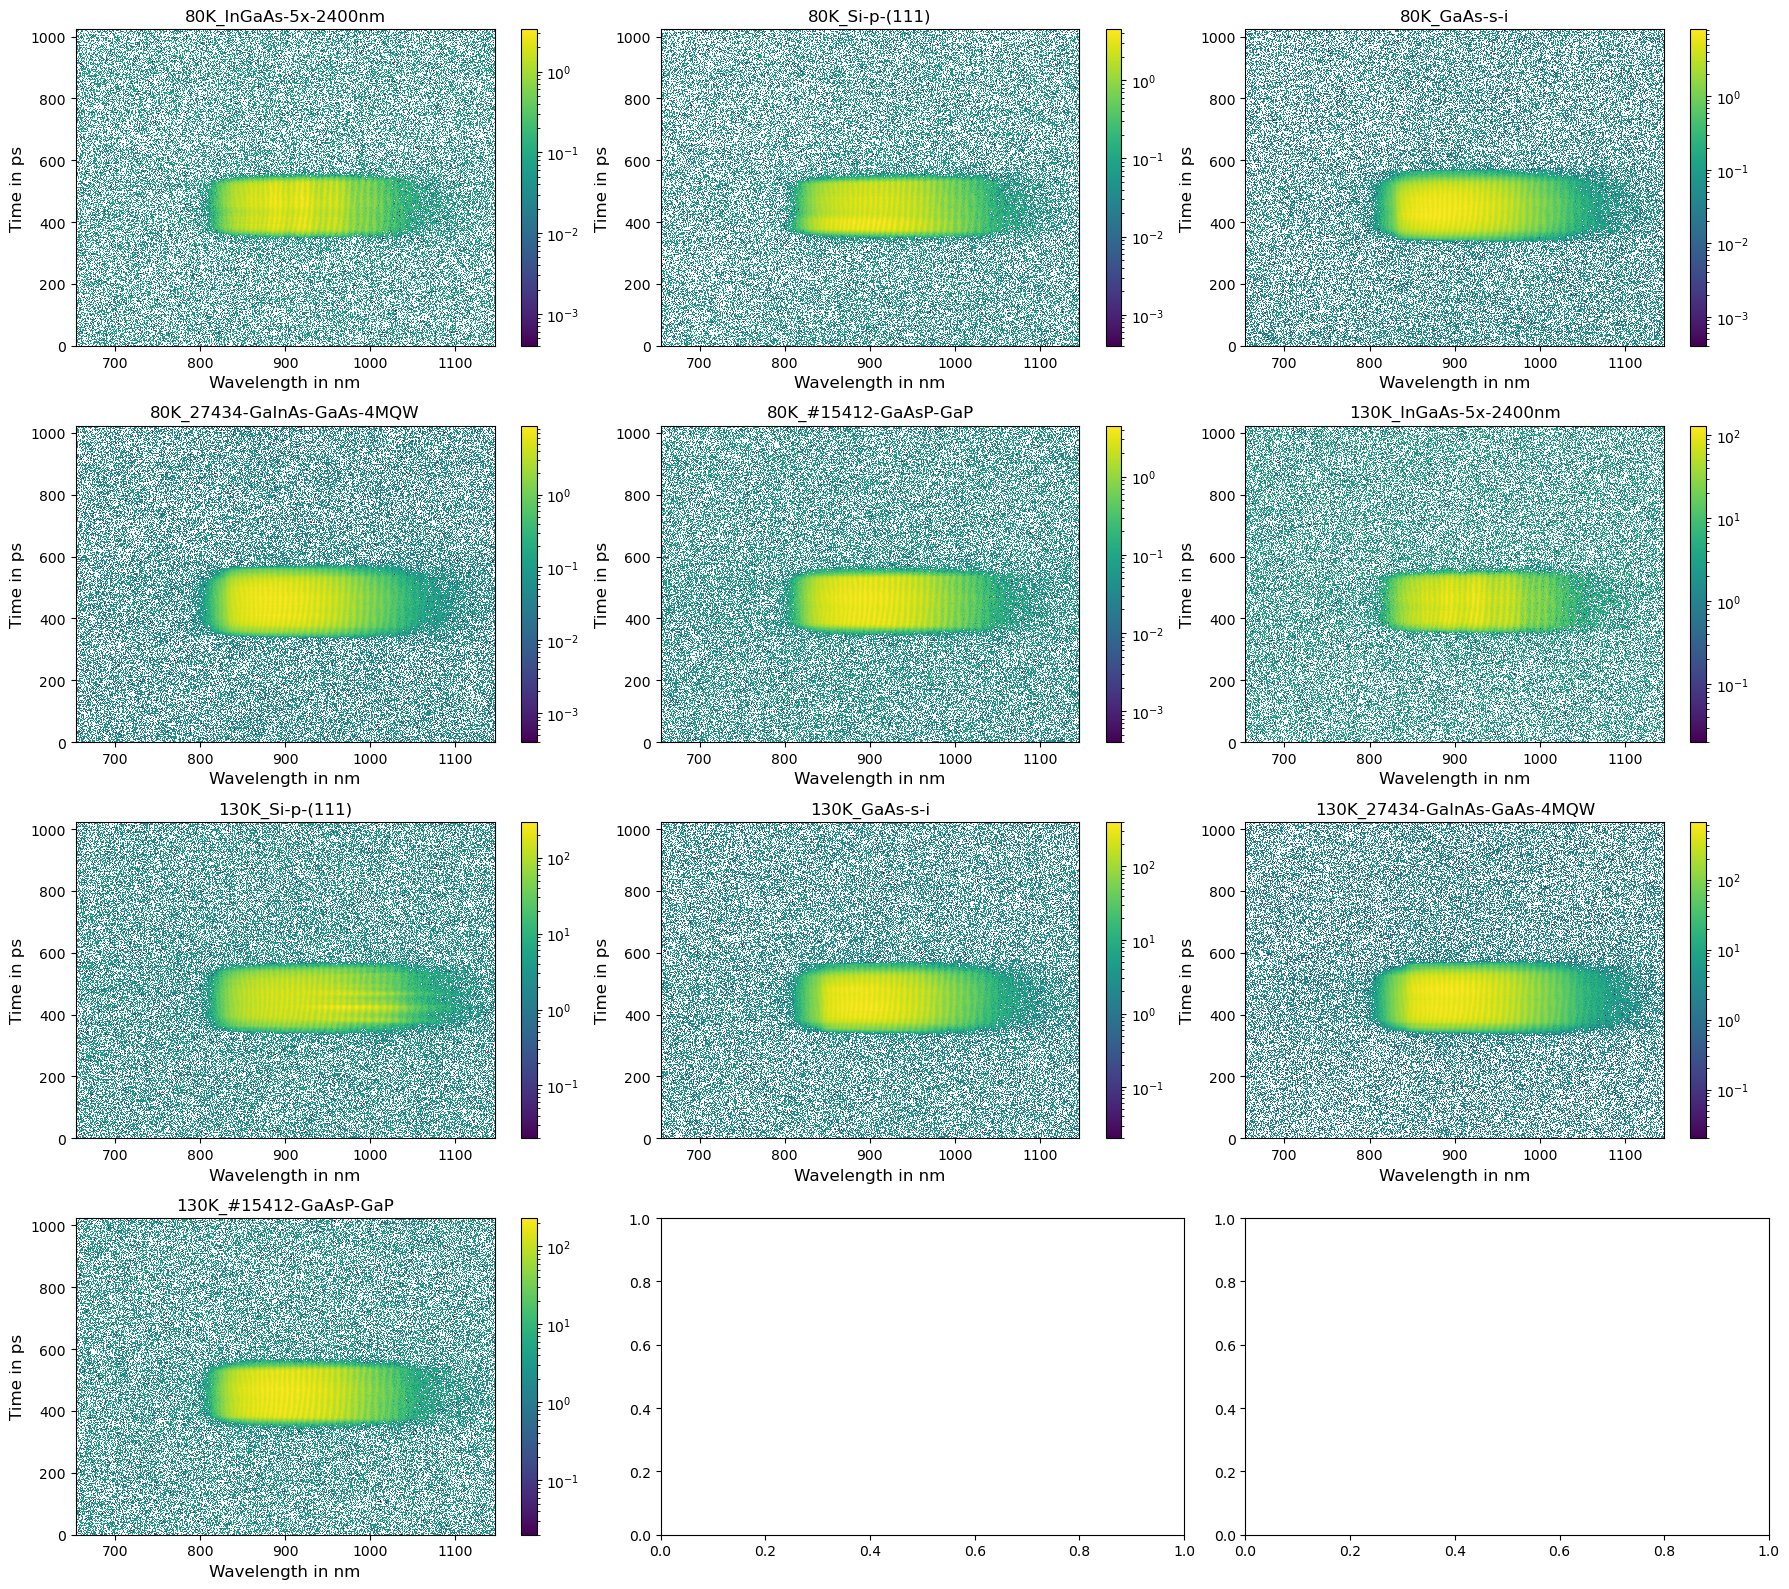

In [48]:
#Choose an appropriate area of you df to analyze

plot_all_img_in_dict(img_dict,line_length=3)
plt.show() 

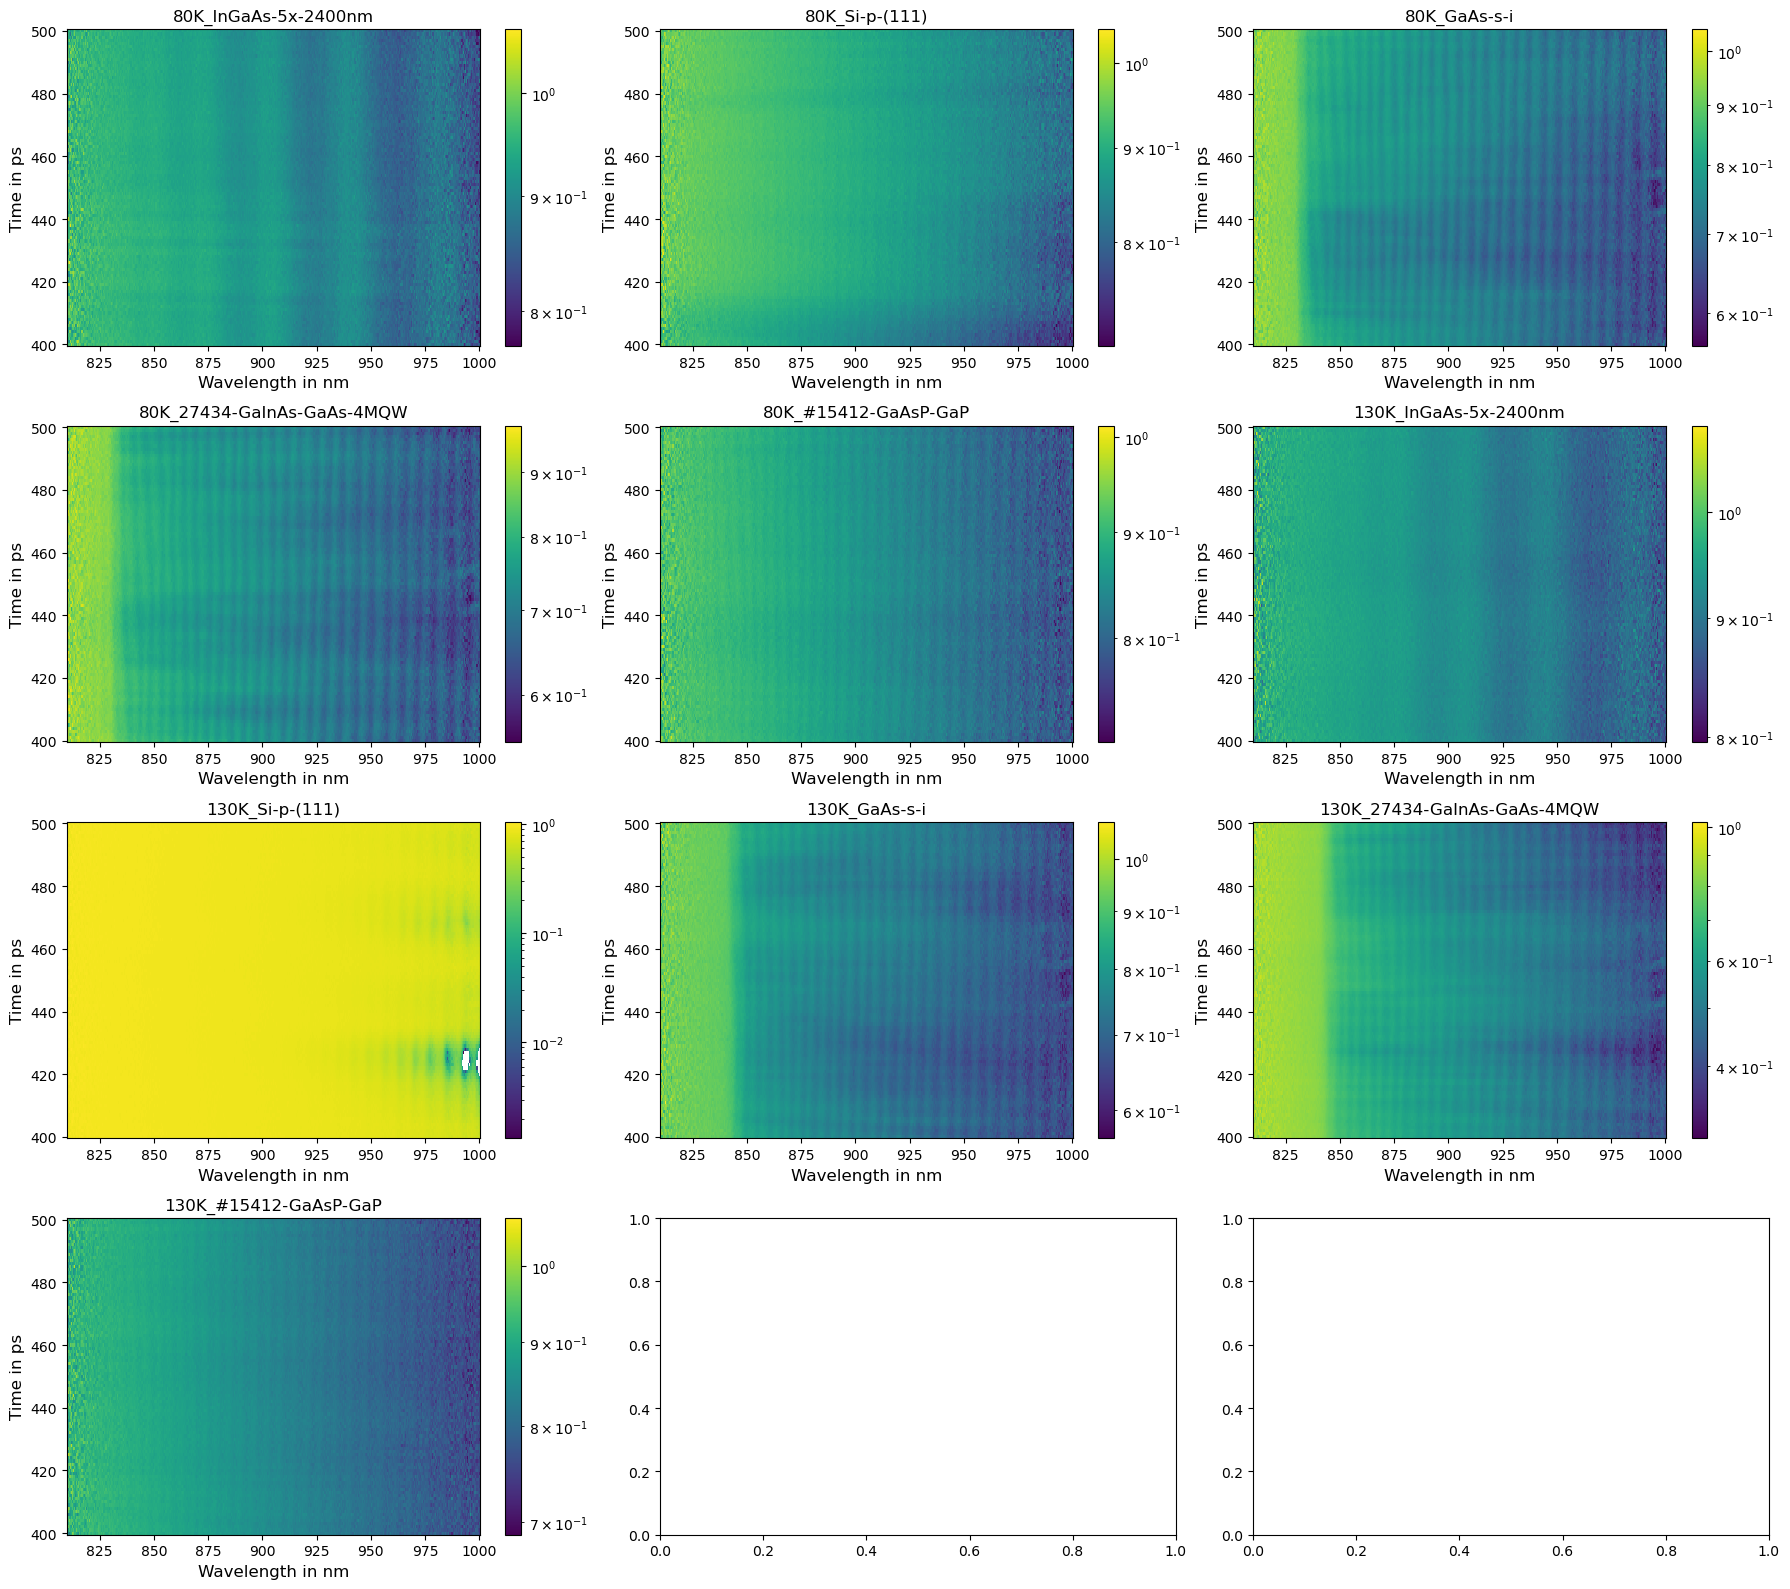

In [21]:
#Choose an appropriate area of your df to analyze
wl_min=810
wl_max=1000
ymin=400
ymax=500

plot_all_abs_in_dict(img_dict, from_wl=wl_min,to_wl=wl_max,from_y=ymin, to_y=ymax,line_length=3)
plt.show()

    

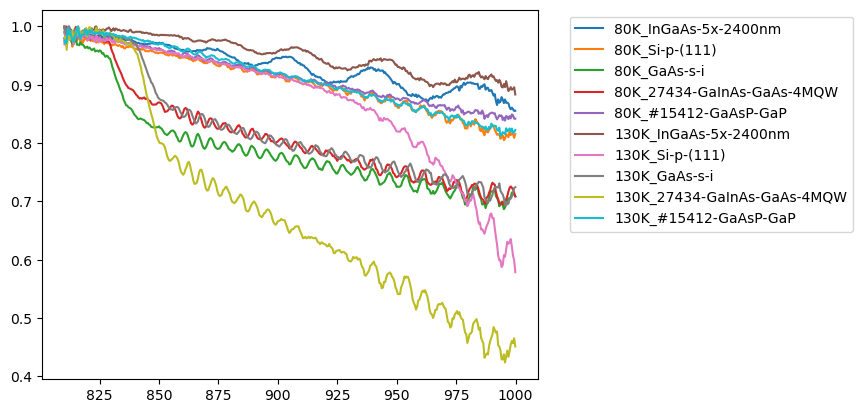

In [72]:
for i in img_dict: #Calculate the abs-spectra within the frame previously chosen
    sum_=img_dict[i].abs_ser.loc[810:1000]
    max_=dc(max(sum_))
    sum_=sum_/max_
    plt.plot(sum_,label=i)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

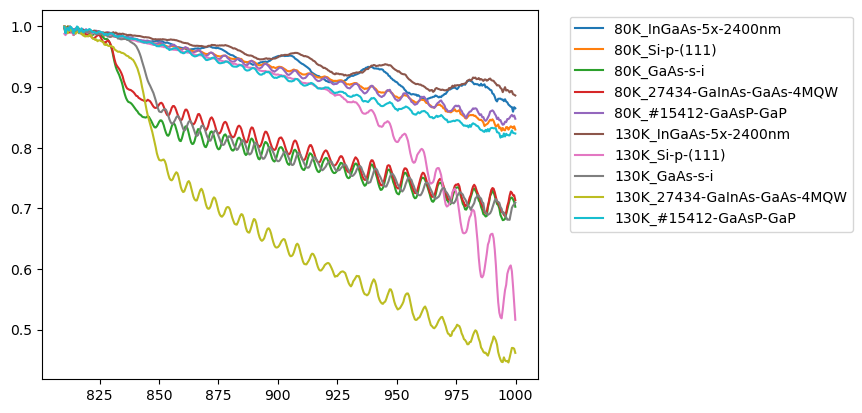

In [65]:
for i in img_dict: #Calculate the abs-spectra within the frame previously chosen
    sum_=np.sum(img_dict[i].abs.loc[400:500,810:1000])
    max_=dc(max(sum_))
    sum_=sum_/max_
    plt.plot(sum_,label=i)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Plot selected data

In [37]:
from scipy.signal import butter, lfilter, freqz, filtfilt
import matplotlib.pyplot as plt


def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    #y = lfilter(b, a, data)
    y = filtfilt(b, a, data)
    return y


def fourier_filter(ser_,order,fs,cutoff, fres="yes"):
    
    b, a = butter_lowpass(cutoff, fs, order)

    if fres=="yes":
        
        # Plotting the frequency response.
        w, h = freqz(b, a, worN=8000)
        plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
        plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
        plt.vlines(cutoff, color='k',ymin=0,ymax=1)
        plt.xlim(0, 0.5*fs)
        plt.title("Lowpass Filter Frequency Response")
        plt.xlabel('Frequency [Hz]')
        plt.grid()
        plt.show()

    data=dc(ser_)
    norm=(data.values-min(data.values))/(max(data.values)-(min(data.values)))
    # Filtering and plotting
    y = butter_lowpass_filter(norm, cutoff, fs, order)

    #plt.plot(data.index, norm, 'b-', label='data')
    #plt.plot(data.index, y, 'g-', linewidth=2, label='filtered data')
    #plt.xlabel('Time [sec]')
    #plt.grid()
    #plt.legend()
    #plt.show()
    
    return pd.Series(index=data.index,data=y)


def fourier_filter_dict(dict_,order,fs,cutoff, fres="yes"):
    new_dict={}
    for i in dict_:
        new_dict[i]=fourier_filter(dict_[i],order,fs,cutoff, fres)
    return new_dict
        
        

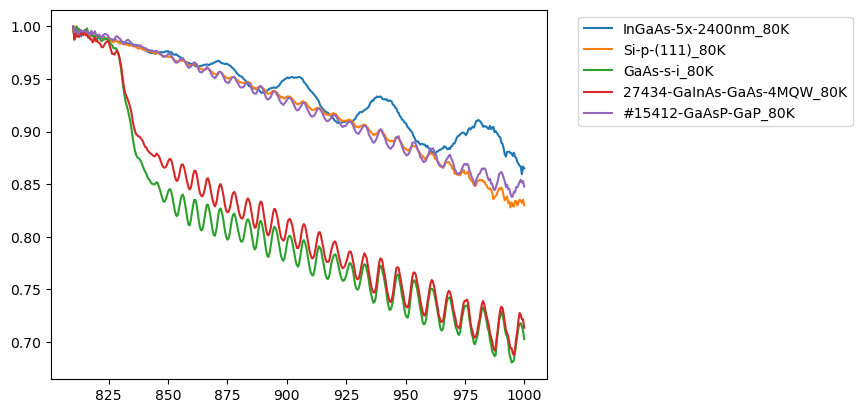

In [27]:
dict_=dc(dict_80K) #Select the dict you want to analyze
#plot_all_abs_in_dict(dict_, from_wl=wl_min,to_wl=wl_max,from_y=ymin, to_y=ymax,line_length=3)
plt.show()
for i in dict_: #Calculate the abs-spectra within the frame previously chosen
    sum_=np.sum(dict_[i].abs.loc[ymin:ymax,wl_min:wl_max])
    max_=dc(max(sum_))
    sum_=sum_/max_
    plt.plot(sum_,label=i)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

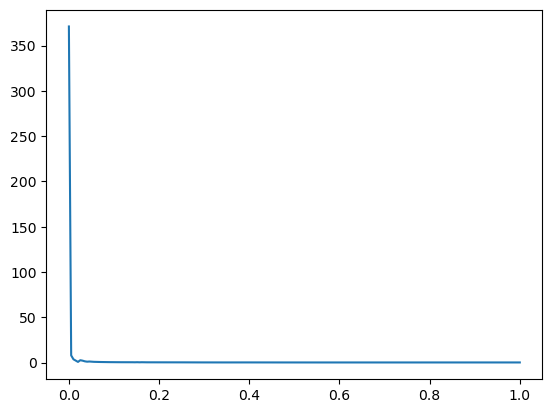

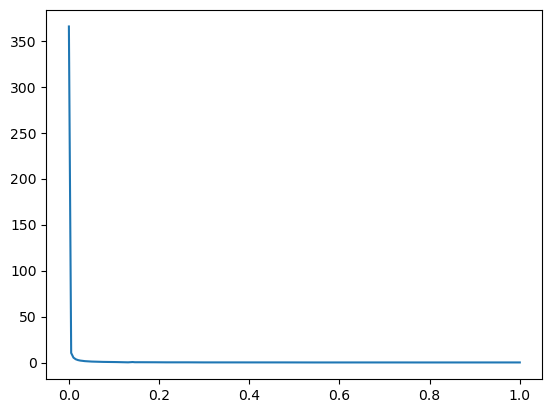

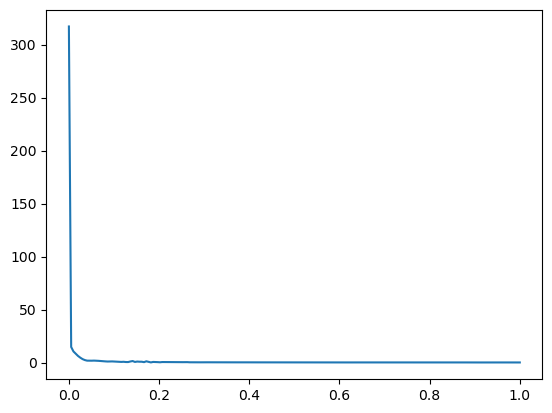

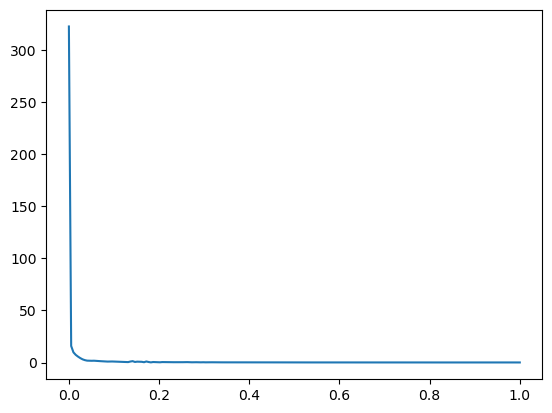

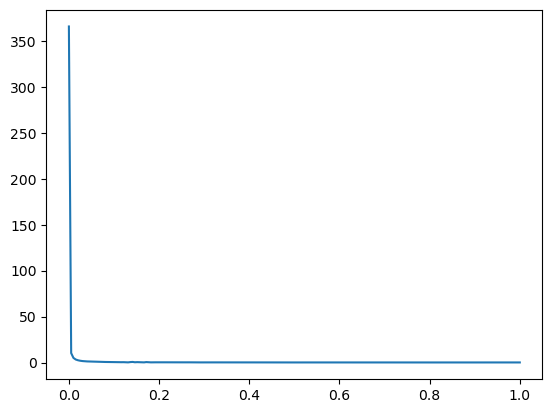

No handles with labels found to put in legend.


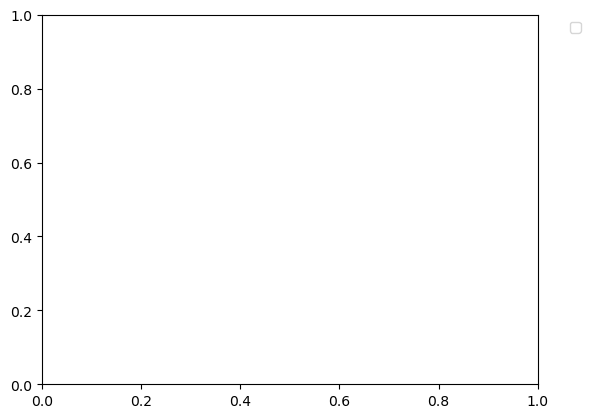

In [50]:
from scipy.fft import fft, fftfreq, rfft, rfftfreq

# Number of samples in normalized_tone

dict_=dc(dict_80K) #Select the dict you want to analyze
#plot_all_abs_in_dict(dict_, from_wl=wl_min,to_wl=wl_max,from_y=ymin, to_y=ymax,line_length=3)
plt.show()
for i in dict_: #Calculate the abs-spectra within the frame previously chosen
    sum_=np.sum(dict_[i].abs.loc[ymin:ymax,wl_min:wl_max])
    max_=dc(max(sum_))
    sum_=sum_/max_
    data=sum_
    SAMPLE_RATE=int(len(data.values)/(data.index[-1]-data.index[0]))
    DURATION=int((data.index[-1]-data.index[0]))
    N=int(len(data.values))

    yf = rfft(data.values)
    xf = rfftfreq(N, 1/SAMPLE_RATE)

    #plt.xlim(0,0.3)
    #plt.ylim(0,1)
    plt.plot(xf, np.abs(yf))
    plt.show()
#plt.plot(sum_,label=i)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



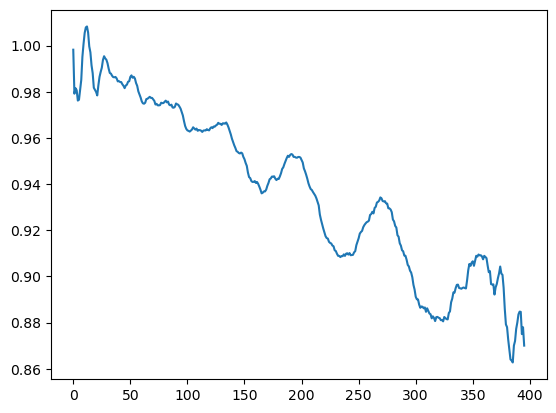

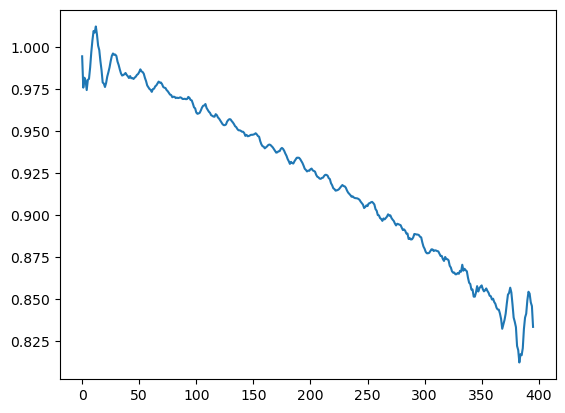

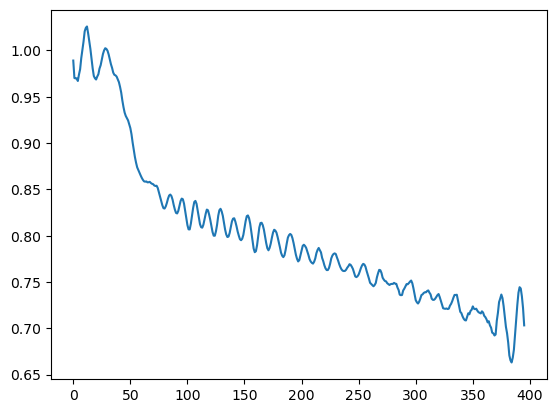

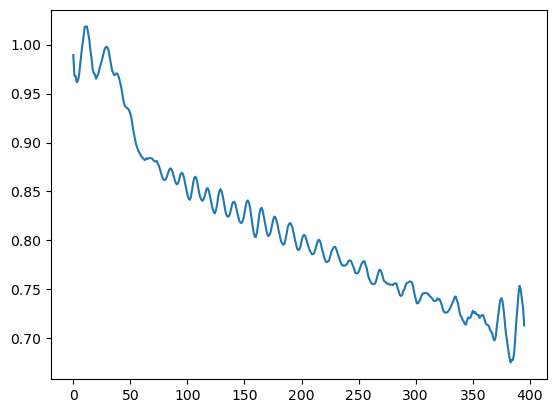

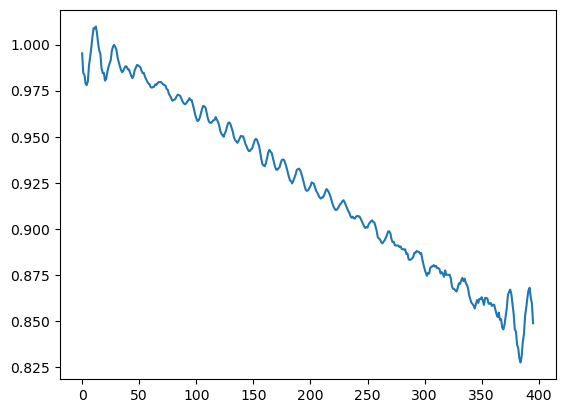

No handles with labels found to put in legend.


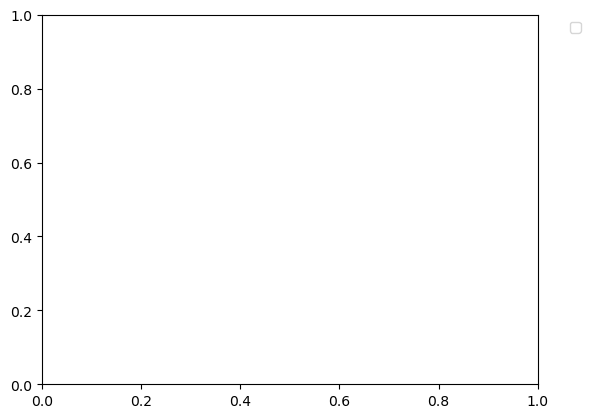

In [80]:
from scipy.fft import fft, fftfreq, rfft, rfftfreq
from scipy.fft import irfft

# Number of samples in normalized_tone

dict_=dc(dict_80K) #Select the dict you want to analyze
#plot_all_abs_in_dict(dict_, from_wl=wl_min,to_wl=wl_max,from_y=ymin, to_y=ymax,line_length=3)
plt.show()
for i in dict_: #Calculate the abs-spectra within the frame previously chosen
    sum_=np.sum(dict_[i].abs.loc[ymin:ymax,wl_min:wl_max])
    max_=dc(max(sum_))
    sum_=sum_/max_
    data=sum_
    SAMPLE_RATE=int(len(data.values)/(data.index[-1]-data.index[0]))
    DURATION=int((data.index[-1]-data.index[0]))
    N=int(len(data.values))

    yf = rfft(data.values)
    xf = rfftfreq(N, 1/SAMPLE_RATE)
    
    points_per_freq = len(xf) /  (SAMPLE_RATE/2 )

    # Our target frequency is 4000 Hz
    target_idx = int(points_per_freq * 0.13)
    #yf[target_idx - 5 : -1] = 0
    yf[target_idx - 5 : target_idx+5] = 0

    #plt.xlim(0,0.3)
    #plt.ylim(-1,1)
    new_sig = irfft(yf)
    #plt.plot(xf, np.abs(yf))
    plt.plot(new_sig[:1000])
    plt.show()
#plt.plot(sum_,label=i)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



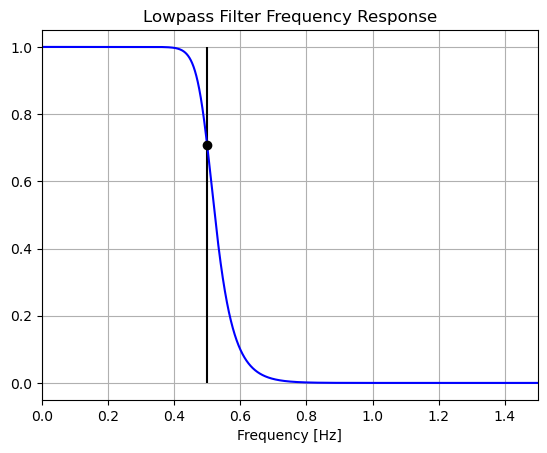

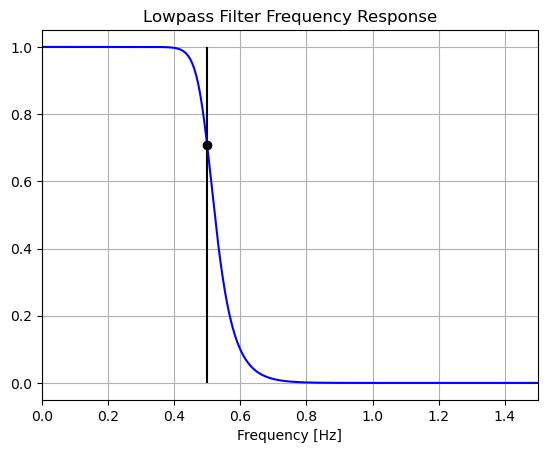

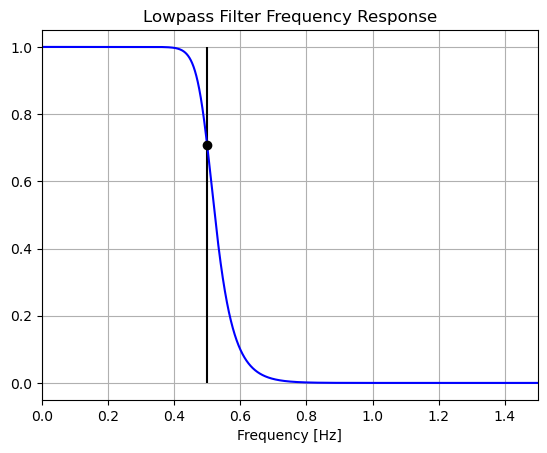

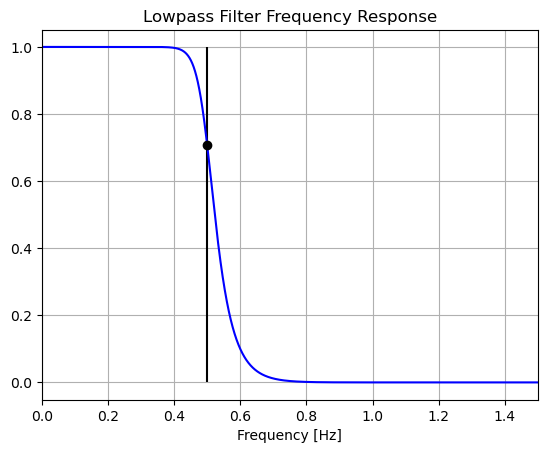

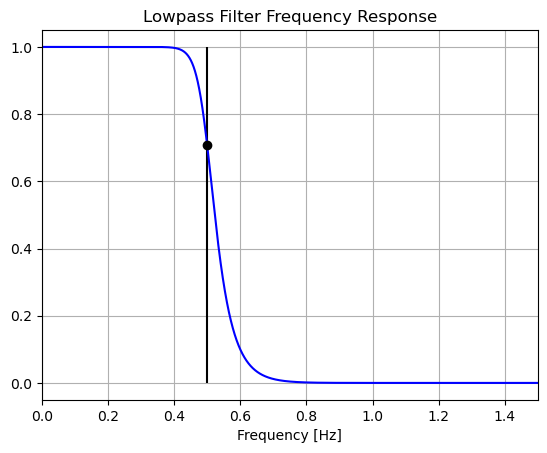

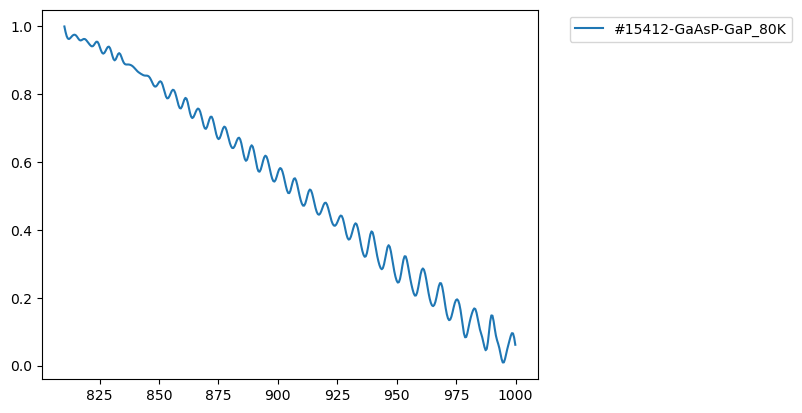

In [144]:
dict_=dc(dict_80K) #Select the dict you want to analyze
#plot_all_abs_in_dict(dict_, from_wl=wl_min,to_wl=wl_max,from_y=ymin, to_y=ymax,line_length=3)
plt.show()
for i in dict_: #Calculate the abs-spectra within the frame previously chosen
    sum_=np.sum(dict_[i].abs.loc[ymin:ymax,wl_min:wl_max])
    max_=dc(max(sum_))
    sum_=sum_/max_
    sum_=fourier_filter(sum_,order=10,fs=3,cutoff=0.5, fres="yes")
    plt.plot(sum_,label=i)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# !!!Das eigentliche Programm endet hier!!!

### Auflistung aller Daten in den jeweiliegen Dictionarys

In [ ]:
print("Namen der Signale: Temperatur_Postition des Polaristors_Name der zugehörigen Referenz")
print("")#Diese Fenster gbt dir ene Auflistung aller Keywörter in den dictionarys aus
show_dict(img_dict)
print("Namen der Referenzen")
print("")
show_dict(ref_l)
print("Namen der Backgroudns")
print("")
show_dict(bg)

### Umwandeln aller Daten in Summenspectra

In [ ]:
plot_all_img_in_dict(ref_l, line_length=2) #Plottet die 2D-Profile aller Datensätze
plt.show()

In [ ]:
help(plot_all_img_in_dict)

In [ ]:
img_dict_1=dc(img_dict) #Beschneidet den Bereich des 2D-Plots
ref_l_1=dc(ref_l)
bg_1=dc(bg)

frame=[300,600] #Ausgewählter Vereich in y-Richtung

for i in img_dict:
    img_dict_1[i].data=dc(img_dict[i].data.iloc[frame[0]:frame[1],:])
for i in ref_l:
    ref_l_1[i].data=dc(ref_l[i].data.iloc[frame[0]:frame[1],:])
for i in bg:
    bg_1[i].data=dc(bg[i].data.iloc[frame[0]:frame[1],:])
plot_all_img_in_dict(img_dict_1, line_length=2)
plt.show()

In [ ]:
sum_dict={} #Aus den EMCCD-Daten werden über Schleifen Summenspektren erstell, die in die links gelisteten Dicitonarys geschrieben werden
sum_ref={}
sum_bg={}

for i in img_dict:
    sum_dict[i]=img_dict[i].sum_spec()
for i in ref_l:
    sum_ref[i]=ref_l[i].sum_spec()
for i in bg:
    sum_bg[i]=bg[i].sum_spec()

In [ ]:
for i in sum_dict:  # Plotten der Summenspektren
    plt.plot(sum_dict[i])
    plt.title(i)
    plt.show()

### Abzug des Backgrounds von allen Signal- und Referenz-Daten (nur einmal ausführen)

In [ ]:
sum_dict_test=dc(sum_dict)
sum_ref_test=dc(sum_ref)
for i in sum_dict_test:
    for j in range(len(sum_dict_test[i].index)):
        sum_dict_test[i].iloc[j]=sum_dict_test[i].iloc[j]-sum_bg["BG00A"].iloc[j]
for i in sum_ref:
    for j in range(len(sum_ref_test[i].index)):
        sum_ref_test[i].iloc[j]=sum_ref_test[i].iloc[j]-sum_bg["BG00A"].iloc[j]
#show_dict(sum_dict_test)

In [ ]:
for i in sum_dict_test:  # Plotten der Summenspektren
    plt.plot(sum_dict_test[i])
    plt.title(i)
    plt.show()

In [ ]:
for i in sum_ref_test:  # Plotten der Summenspektren
    plt.plot(sum_ref_test[i])
    plt.title(i)
    plt.show()

### Erstellen eines Dictionaries für die Absorptionsspektren

In [ ]:
abs_dict={}
for i in sum_dict_test:
    (temp,pol,ref)=i.split("_") #Der Name der Siganldateien enhält unter anderem den Namen der zugehörigen Referenzdatei, dieser wird hier in die Variable "ref" geschrieben
    abs_dict[f"{temp}_{pol}"]=dc(1-(sum_dict_test[i]/sum_ref_test[ref])) #Hier wird der abs-Koeffizient berechnet die Formel ist im Prinzip a=1-signal/ref, die Referenz wird aus dem ref-Dictionary mit der Variable "ref" aufgerufen
        

In [ ]:
for i in abs_dict:
    plt.plot(abs_dict[i].loc[810:1000],label=i)
    plt.legend()
    #plt.ylim(-0.2,1)
    plt.show() # Durch auskommentieren oder löschen dieser Zeile werden alle Kurven in einem Graphen geplottet
plt.show()

### Exportieren der Absorptionsspektren im .csv-Format

In [ ]:
for i in abs_dict: 
    abs_dict[i].to_csv(f"{i}.csv") #Hier könnte noch ein Pfad zu bestimmten Ordnern für die Dateien eingefügt werden
    plt.plot(sum_dict[i])
    plt.show()